# Classification part of task 2 for Winstars AI DS internship test
#### Author: `Dmytro Avdieienko`

In [39]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import random
import cv2

## Prepare data

In [2]:
# Data downloaded in .\Task_2\data\monkey_species from
# https://www.kaggle.com/datasets/slothkong/10-monkey-species
BASE_DIR = Path('../data/monkey_species')
TRAIN_DIR = BASE_DIR / 'training' / 'training'
TEST_DIR = BASE_DIR / 'validation' / 'validation'
LABELS_FILE = BASE_DIR / 'monkey_labels.txt'

# Check
print(f"TRAIN_DIR exists: {TRAIN_DIR.exists()}")
print(f"TEST_DIR exists: {TEST_DIR.exists()}")
print(f"LABELS_FILE exists: {LABELS_FILE.exists()}")

TRAIN_DIR exists: True
TEST_DIR exists: True
LABELS_FILE exists: True


In [3]:
cols = ['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']
labels_df = pd.read_csv(LABELS_FILE, names=cols, skiprows=1)

# Clearing table
labels_df['Label'] = labels_df['Label'].str.strip()
labels_df['Latin Name'] = labels_df['Latin Name'].str.strip()
labels_df['Common Name'] = labels_df['Common Name'].str.strip()

# Labels table
print("Labels information:")
print(labels_df)

Labels information:
  Label             Latin Name                Common Name  Train Images  \
0    n0      alouatta_palliata             mantled_howler           131   
1    n1     erythrocebus_patas               patas_monkey           139   
2    n2         cacajao_calvus                bald_uakari           137   
3    n3         macaca_fuscata           japanese_macaque           152   
4    n4        cebuella_pygmea             pygmy_marmoset           131   
5    n5        cebus_capucinus      white_headed_capuchin           141   
6    n6        mico_argentatus           silvery_marmoset           132   
7    n7       saimiri_sciureus     common_squirrel_monkey           142   
8    n8        aotus_nigriceps  black_headed_night_monkey           133   
9    n9  trachypithecus_johnii             nilgiri_langur           132   

   Validation Images  
0                 26  
1                 28  
2                 27  
3                 30  
4                 26  
5               

In [4]:
common_names = labels_df['Common Name'].str.strip()
print("\nCommon names of monkey species:")
print(common_names)


Common names of monkey species:
0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


In [5]:
# Counting images in each class
print("\nCounting images in each class...")

for label in labels_df['Label']:
    train_path = TRAIN_DIR / label
    test_path = TEST_DIR / label

    train_count = len(list(train_path.glob('*'))) if train_path.exists() else 0
    test_count = len(list(test_path.glob('*'))) if test_path.exists() else 0

    print(f"{label}: {train_count} training images, {test_count} validation images")


Counting images in each class...
n0: 105 training images, 26 validation images
n1: 111 training images, 28 validation images
n2: 110 training images, 27 validation images
n3: 122 training images, 30 validation images
n4: 105 training images, 26 validation images
n5: 113 training images, 28 validation images
n6: 106 training images, 26 validation images
n7: 114 training images, 28 validation images
n8: 106 training images, 27 validation images
n9: 106 training images, 26 validation images


In [17]:
def image_show(num_image, label):
    '''The input parameters are the number of images to display and the class label to select.The function uses the 'os' and 'cv2' modules to randomly select an image from the specified class, reads the image, and displays it on screen using the 'matplotlib' library.
    For each displayed image, a detail window is also shown, indicating the name of the image and which folder it was selected from.
    Finally, the function uses 'plt.show()' to create a single drawing object that groups all displayed images.'''

    for i in range(num_image):
        imgdir = TRAIN_DIR / label
        imgfile = random.choice(os.listdir(imgdir))
        img_path = imgdir / imgfile
        img = cv2.imread(str(img_path))
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

pygmy_marmoset


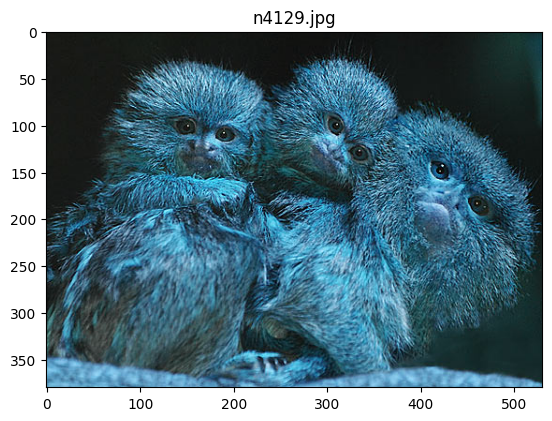

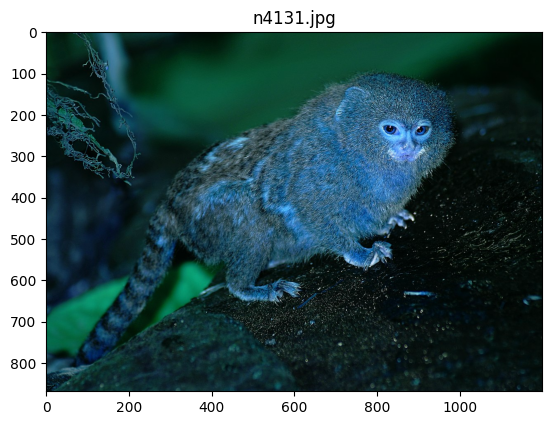

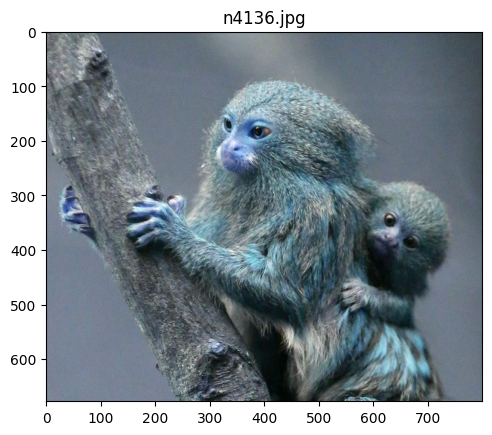

In [18]:
print(common_names[4])
image_show(3,'n4')

## Data augmentation

In [19]:
# Function for creating data generators with augmentation
def create_data_generators(img_height=224, img_width=224, batch_size=32):
    # Generator for training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generator for validation data without augmentation
    valid_datagen = ImageDataGenerator(rescale=1./255)

    # load training data
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # load valid data
    valid_generator = valid_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator

In [20]:
train_generator, valid_generator = create_data_generators()

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [23]:
def visualize_augmentation():
    # Example of image
    sample_class = 'n0'
    sample_dir = os.path.join(TRAIN_DIR, str(sample_class))
    sample_image_name = os.listdir(sample_dir)[0]
    sample_image_path = os.path.join(sample_dir, sample_image_name)

    img = tf.keras.preprocessing.image.load_img(
        sample_image_path,
        target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    augmentation_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    plt.figure(figsize=(10, 10))

    plt.subplot(3, 3, 1)
    plt.title('Original')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))

    i = 1
    for batch in augmentation_datagen.flow(img_array, batch_size=1):
        plt.subplot(3, 3, i+1)
        plt.title(f'Augmented {i}')
        aug_img = tf.keras.preprocessing.image.array_to_img(batch[0])
        plt.imshow(aug_img)
        i += 1
        if i >= 9:
            break

    plt.tight_layout()
    plt.savefig('augmentation_examples.png')
    plt.show()

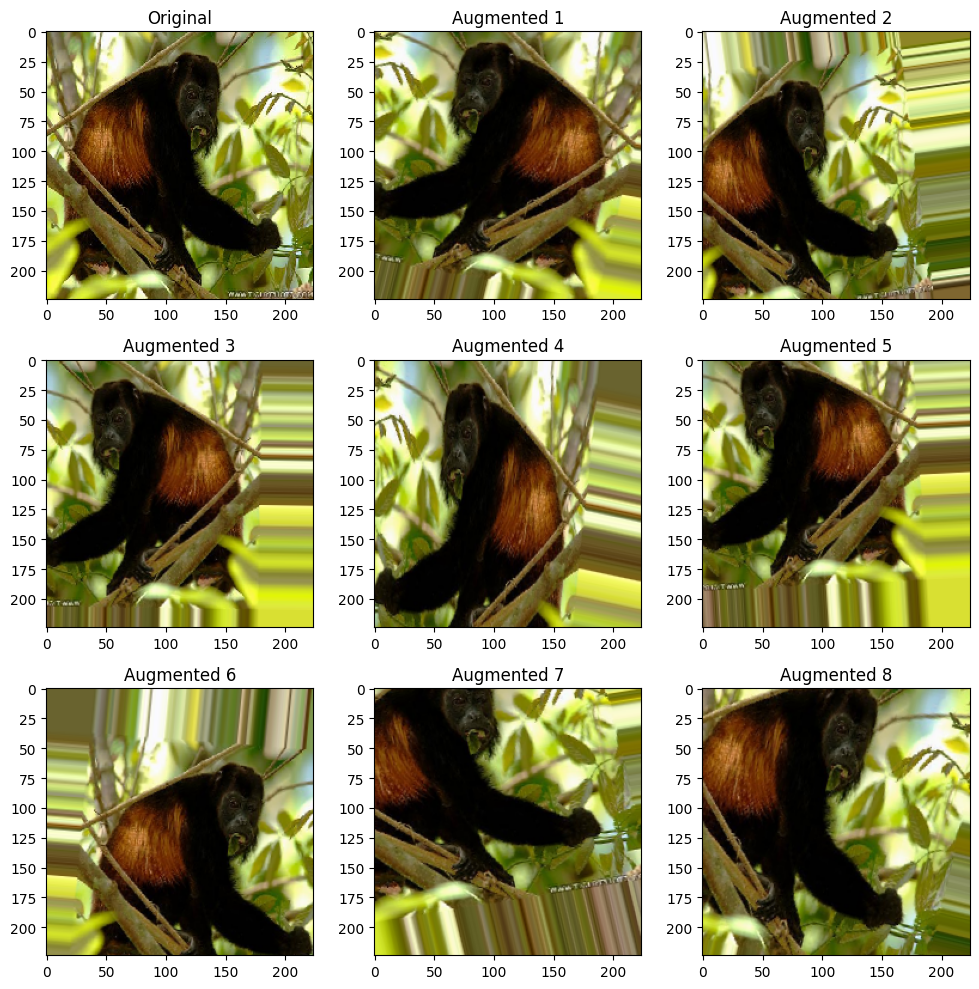

In [24]:
visualize_augmentation()

## Create model

In [48]:
def create_model(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential()

    # 1 convolution
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2 convolution
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 convolution
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flat cnn to dnn layers
    model.add(Flatten())

    # Dense layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [49]:
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

## Train model

In [50]:
def train_model(model, train_generator, valid_generator, epochs=50):
    # callback
    checkpoint = ModelCheckpoint(
        'best_monkey_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # train
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=valid_generator.samples // valid_generator.batch_size,
        # callbacks=[checkpoint, early_stopping]
        callbacks=[checkpoint]
    )

    return model, history

In [51]:
model, history = train_model(model, train_generator, valid_generator, epochs=100)

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 2.3795 - accuracy: 0.1191
Epoch 1: val_accuracy improved from -inf to 0.25781, saving model to best_monkey_model.h5
34/34 [==============================] - 17s 472ms/step - loss: 2.3795 - accuracy: 0.1191 - val_loss: 2.2109 - val_accuracy: 0.2578
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 2.1430 - accuracy: 0.2373
Epoch 2: val_accuracy improved from 0.25781 to 0.36719, saving model to best_monkey_model.h5
34/34 [==============================] - 16s 465ms/step - loss: 2.1430 - accuracy: 0.2373 - val_loss: 1.9400 - val_accuracy: 0.3672
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 1.9672 - accuracy: 0.3039
Epoch 3: val_accuracy improved from 0.36719 to 0.47656, saving model to best_monkey_model.h5
34/34 [==============================] - 16s 464ms/step - loss: 1.9672 - accuracy: 0.3039 - val_loss: 1.7180 - val_accuracy: 0.4766
Epoch 4/100
34/34 [========================

## Visualizations

In [52]:
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

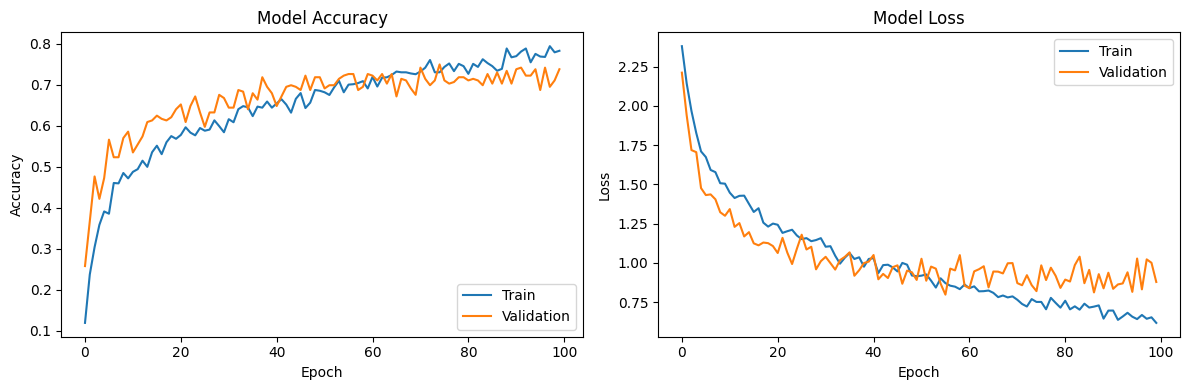

In [53]:
plot_training_history(history)

## Conclusion

Saved model with 75% accuracy